In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainDatasetPath = '/content/drive/My Drive/data/train/'
testDatasetPath = '/content/drive/My Drive/data/test/'
test_noiseDataSetPath = '/content/drive/My Drive/data/test_noise/'
mtec_testDataSetPath = '/content/drive/My Drive/data/mtec_test/'
csvPath = '/content/drive/My Drive/data/ImageName_with_Class.csv'

In [ ]:
import os
import torch
import pandas as pd
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file, names=['Image Name', 'Image Class'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
class DataSubset(Dataset):
  def __init__(self, subset, transform=None, target_transform=None):
        self.subset = subset
        self.transform = transform
        self.target_transform = target_transform

  def __len__(self):
        return len(self.subset)

  def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
train_transforms = transforms.Compose ([transforms.ToPILImage(),
                                        transforms.Resize((220,200)),
                                        #.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                                       #transforms.RandomRotation(10),
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

test_transforms =  transforms.Compose ([transforms.Resize((220,200)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

val_transforms = test_transforms

In [ ]:
dataset = CreateDataset(csv_file = csvPath, img_dir = trainDatasetPath)
trainLength = int(len(dataset) * 0.8)
valLength = len(dataset) - trainLength

#print(len(dataset))
#print(trainLength)
#print(valLength)

trainDataset , valDataset = torch.utils.data.random_split(dataset, [trainLength, valLength])

trainingData = DataSubset(subset = trainDataset, transform = train_transforms)
validationData = DataSubset(subset = valDataset, transform = val_transforms)

In [ ]:

#testDataset = torchvision.datasets.ImageFolder(root = testDatasetPath, transform = test_transforms)


In [ ]:
batchSize = 16
trainDataloader = torch.utils.data.DataLoader(dataset = trainingData, batch_size = batchSize, shuffle = True, pin_memory=True)
print(trainDataloader)
data = next(iter(trainDataloader))
print(data[0].mean())
valDataloader = torch.utils.data.DataLoader(dataset = validationData, batch_size = batchSize, shuffle = True)

RuntimeError: ignored

TypeError: ignored

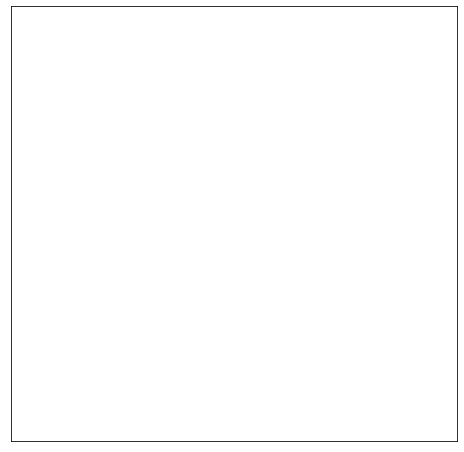

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

show_batch(trainDataloader)